In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
pandas.set_option('display.max_colwidth', 200)
np.random.seed(127205)

In [2]:
# preprocessing

def cleanup(tweets):
    tweets = tweets.dropna()
    tweets = tweets.drop(columns=['Id'])
    tweets = tweets[tweets.Category != 'Tweet']
    tweets = tweets[tweets.Tweet != 'Not Available']
    tweets = tweets[tweets.Tweet != '']
    return tweets

import re
from nltk.tokenize.casual import casual_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
import string

stops = {'in', 'of', 'at', 'a', 'the', 'to', 'on', 'and', 'it'}
stops.update(string.punctuation)
stops.difference_update('?!')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tag_for_lemmatizer(tag):
    if tag.startswith('NN'):
        return 'n'
    if tag.startswith('VB'):
        return 'v'
    return 'a'

def preprocess(text, lemmatize=True):
    if not text or type(text) != str:
        return ''

    text = text.lower()
    text = re.sub(r"https?://[^\s]+", '', text) # hyperlinks
    text = re.sub(r"\@\w+", '', text) # mentions
    text = re.sub(r"#", '', text) # hashtags
    text = re.sub(r"\d+\w*", '', text) # numbers
    text = re.sub(r"'s", '', text) # possesive
    text = re.sub(r"n't", ' not', text) # contractions
    text = re.sub(r"'m", ' am', text)
    text = re.sub(r"'s", ' is', text)
    text = re.sub(r"'re", ' are', text)
    
    words = [word for word in casual_tokenize(text) if word not in stops]
    
    if lemmatize:
        words = [
            lemmatizer.lemmatize(word, tag_for_lemmatizer(tag))
            for word, tag in pos_tag(words)
        ]
    else:
        words = [
            stemmer.stem(word)
            for word in words
        ]
    text = ' '.join(words)
    return text

In [3]:
# load train set

tweets = pandas.read_csv('data/train.csv')
tweets = cleanup(tweets)
tweets.Tweet = tweets.Tweet.apply(preprocess, lemmatize=True)
tweets

,Category,Tweet
1,neutral,io app transport security mm need check if my party network pod support
2,neutral,mar if you have an ios device you should download our app too
3,negative,my phone do not run late io which may account for problem other day .. time be replace
4,positive,not sure how start your publication io ? we'll be live help with ask me anything session today friday
5,neutral,two dollar tuesday be here with forklift quickkey for io suite for page for just today
...,...,...
5963,positive,ok ed let do this zlatan greizmann laporte tomorrow make happen
5964,neutral,goal level zlatan by friday ? post every other day dsgs vine by
5965,neutral,would not surprise me if we enquired.he ca not be happy play fiddle zlatan but he not worth psg ask price
5966,neutral,rib injury for zlatan against russia be big blow if he miss austria game tuesday chance for new sunderland striker toivonen safc


In [4]:
# convert text to sequences

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets.Tweet)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(tweets.Tweet)

Using TensorFlow backend.


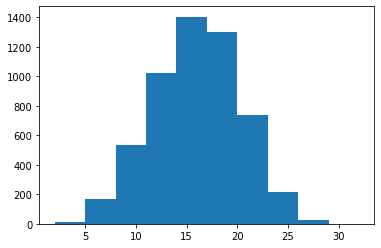

array([[   0,    0,    0, ...,  905, 4080,  284],
       [   0,    0,    0, ...,  122,  420,  210],
       [   0,    0,    0, ...,   24,    1,  906],
       ...,
       [   0,    0,    0, ...,  648,  289,  756],
       [   0,    0,    0, ..., 1017, 9219, 9220],
       [   0,    0,    0, ...,   65,  463,  334]], dtype=int32)

In [5]:
# pad sequences

lengths = [len(seq) for seq in sequences]
plt.hist(lengths)
plt.show()

max_words = 30
sequences = sequence.pad_sequences(sequences, maxlen=max_words)
sequences

In [6]:
# convert categories to one-hot vectors

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(tweets.Category.values.reshape(-1, 1))
num_classes = len(ohe.get_feature_names())

In [7]:
# split data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sequences, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [8]:
# use Google word2vec embeddings

import gensim

# download it from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
word2vec_file = 'models/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file, binary=True)

In [9]:
embedding_dim = 300

embedding_weights = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if word in word2vec:
        embedding_weights[idx, :] = word2vec[word]

In [10]:
# setup and train neural network

from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

def create_model(embedding_weights, num_classes, spatial_dropout=0.5, lstm_dropout=0.5, recurrent_dropout=0.5):
    vocab_size, embedding_dim = embedding_weights.shape
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_words, weights=[embedding_weights], trainable=False),
        SpatialDropout1D(spatial_dropout),
        LSTM(100, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout),
        Dense(num_classes, activation='softmax'),
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(embedding_weights, num_classes)
model.summary()

epochs = 6
batch_size = 32

model.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=epochs, batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           2766600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 2,927,303
Trainable params: 160,703
Non-trainable params: 2,766,600
_________________________________________________________________
Train on 3468 samples, validate on 868 samples
Epoch 1/6
3468/3468 [==============================] - 4s 1ms/step - loss: 1.0072 - accuracy: 0.4801 - val_loss: 0.9591 - val_accuracy: 0.5242
Epoch 2/6
3468/3468 [=========================

In [11]:
# check against the test set

from sklearn.metrics import confusion_matrix, accuracy_score

predictions = model.predict_classes(x_test)
truth = y_test.argmax(1)

print(confusion_matrix(truth, predictions))
print(accuracy_score(truth, predictions))

[[  9  81  94]
 [  3 122 257]
 [  0  36 483]]
0.5658986175115207


In [12]:
# optimize dropout hyperparameters

import itertools

values = np.arange(1, 4) / 6
scores = {}

for params in itertools.product(values, repeat=3):
    model = create_model(embedding_weights, num_classes, *params)
    model.fit(x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=epochs, batch_size=batch_size, verbose=0)
    
    accuracy = accuracy_score(truth, model.predict_classes(x_test))
    print(params, accuracy)
    scores[params] = accuracy

best_params = max(scores, key=scores.get)

(0.16666666666666666, 0.16666666666666666, 0.16666666666666666) 0.5981566820276498
(0.16666666666666666, 0.16666666666666666, 0.3333333333333333) 0.6055299539170507
(0.16666666666666666, 0.16666666666666666, 0.5) 0.6082949308755761
(0.16666666666666666, 0.3333333333333333, 0.16666666666666666) 0.6
(0.16666666666666666, 0.3333333333333333, 0.3333333333333333) 0.5926267281105991
(0.16666666666666666, 0.3333333333333333, 0.5) 0.5935483870967742
(0.16666666666666666, 0.5, 0.16666666666666666) 0.5963133640552996
(0.16666666666666666, 0.5, 0.3333333333333333) 0.5972350230414747
(0.16666666666666666, 0.5, 0.5) 0.5907834101382489
(0.3333333333333333, 0.16666666666666666, 0.16666666666666666) 0.5880184331797235
(0.3333333333333333, 0.16666666666666666, 0.3333333333333333) 0.6092165898617512
(0.3333333333333333, 0.16666666666666666, 0.5) 0.5935483870967742
(0.3333333333333333, 0.3333333333333333, 0.16666666666666666) 0.6064516129032258
(0.3333333333333333, 0.3333333333333333, 0.3333333333333333)

In [13]:
best_params

(0.3333333333333333, 0.16666666666666666, 0.3333333333333333)

In [14]:
# train on entire set with best params

model = create_model(embedding_weights, num_classes, *best_params)
model.fit(sequences, y, epochs=epochs, batch_size=batch_size)

Epoch 1/6
5421/5421 [==============================] - 5s 935us/step - loss: 0.9610 - accuracy: 0.5185
Epoch 2/6
5421/5421 [==============================] - 5s 857us/step - loss: 0.8962 - accuracy: 0.5632
Epoch 3/6
5421/5421 [==============================] - 5s 847us/step - loss: 0.8764 - accuracy: 0.5805
Epoch 4/6
5421/5421 [==============================] - 5s 849us/step - loss: 0.8614 - accuracy: 0.5888
Epoch 5/6
5421/5421 [==============================] - 5s 888us/step - loss: 0.8461 - accuracy: 0.6003
Epoch 6/6
5421/5421 [==============================] - 5s 869us/step - loss: 0.8404 - accuracy: 0.6008


In [15]:
# test on our own input

def classify(text):
    text = preprocess(text)
    test_seq = tokenizer.texts_to_sequences([text])
    test_seq = sequence.pad_sequences(test_seq, maxlen=max_words)
    predictions = model.predict_classes(test_seq)
    return ohe.categories_[0][predictions[0]]

phrases = ["I loved it!", "I don't know what to say", "What a fucking piece of shit!"]
{ phrase: classify(phrase) for phrase in phrases }

{'I loved it!': 'positive',
 "I don't know what to say": 'neutral',
 'What a fucking piece of shit!': 'negative'}

In [16]:
# predict categories on the external test set

def classify_array(texts):
    texts = [preprocess(text) for text in texts]
    sequences = tokenizer.texts_to_sequences(texts)
    sequences = sequence.pad_sequences(sequences, maxlen=max_words)
    predictions = model.predict_classes(sequences)
    return ohe.categories_[0][predictions]

test_tweets = pandas.read_csv('data/test.csv', dtype={'Id': str, 'Tweet': str})
test_tweets['Category'] = classify_array(test_tweets.Tweet)

with open('predictions.csv', 'wt') as f:
    f.write("Id,Category\n")
    for i, row in test_tweets.iterrows():
        f.write(f"{row.Id},{row.Category}\n")

In [17]:
test_tweets[['Tweet', 'Category']].sample(20)

,Tweet,Category
3792,"Two top Senate investigators offered potential immunity Tuesday to Bryan Pagliano, the staffer who set up the email server in HILLARY",neutral
1076,Got the new PC up and running! Batman looks GLORIOUS!! We'll be casting it tomorrow! See you at 11am PST!,positive
1925,Finally it's Sunday Funday! Whether you were out seeing Tim McGraw or watching Conor McGregor win the fight... http://t.co/83pta9TIDA,positive
3949,someone wanna watch the sun rise and go to IHOP?,positive
1273,my life consists of taking care of Bentley and waiting for Under the Dome every thurs.,positive
529,"'Angela Merkel' stars in lesbian magazine ad: Wednesday sees the launch of new magazine ""Straight,"" aimed at g... http://t.co/7hUcJ0F0qI",positive
3750,@ianbremmer @Eagle_Vision I'm sure Hillary kept a copy of all the original emails somewhere. Where is the 5th thumb-drive Hillary?,neutral
757,This may have changed my mind about buying an Apple Watch. http://t.co/7uCLCt0ydK,positive
762,"I really expected an Apple Watch to be a bit smarter than just telling me to stand up after I just sat down, only because it's 4:50pm.",neutral
735,"Mobile News AppYea Prepping New Mobile App for Apple Watch - On Tuesday morning, MMW was briefed by the crew at Ap... http://t.co/SA5Cl5CGvg",positive
